In [1]:
import pandas as pd
import numpy as np
import os
from utils import *
import bt
pd.set_option('display.max_rows', 100)

In [2]:
inter_data_folder = './inter_data'
data_folder = './data'
weights_df = pd.read_csv(os.path.join(inter_data_folder, 'weights_optimize.csv'), 
                         index_col=0, 
                         parse_dates=True)

# this one i do not get the ret for any date, so just skip it
weights_df.drop(['990018.XSHG'], axis=1, inplace=True)

history = pd.read_csv(os.path.join(data_folder, 'history.csv'), index_col=0, parse_dates=True)
history['ret'] = history.groupby('code')['close'].pct_change()
ret_df = history.pivot_table(index=history.index, columns='code', values='ret')
close_df = history.pivot_table(index=history.index, columns='code', values='close').fillna('ffill')

index_history = pd.read_csv(os.path.join(data_folder, 'index_history.csv'), index_col=0, parse_dates=True)
index_history['ret'] = index_history['close'].pct_change()

index_weights = fill_weights()
index_weights.drop(exclude_codes, axis=1, inplace=True)

close_df = history.pivot_table(index=history.index, columns='code', values='close').copy()

# for doing the backtest purpose, the weights optimization should handle it correctly
# for 601607, I do not get the return before 2010(it is a MA), so I just backfill it, and never trade it before 2010
close_df.fillna(method='ffill', inplace=True)
close_df['601607.XSHG'].fillna(method='bfill', inplace=True)

equal_weight_df = weights_df.copy()
equal_weight_df = np.sign(equal_weight_df).div(np.sign(equal_weight_df.abs()).sum(axis=1), axis=0)


Weight Constraints

In [3]:
# Weights Constraints
# 1. no short position
# 2. add up to 1
# 3. turnover is less than 15%
# 4. no deviation from 3%
print(f'weight is all >= 0: {np.all(weights_df) >= 0}')
print(f'weight is added up to 1: {np.max(np.abs(weights_df.sum(axis=1)-1) < 1e-6)}')


weight is all >= 0: True
weight is added up to 1: True


In [4]:
# 3. turnover is less than 15%
# This is breached mostly because removal of the stock, 
# mainly on those index rebalance date where we need to remove stocks that no longer in the list
weights_df.diff().abs().sum(axis=1).loc[(weights_df.diff().abs().sum(axis=1) - 0.15) > 0].to_frame()

,0
time,
2006-04-28,0.163377
2007-01-31,0.267867
2007-04-30,0.182158
2007-05-31,0.180639
2007-07-31,0.317420
2007-10-31,0.180540
2007-11-30,0.170251
2008-01-31,0.242234
2008-07-31,0.214403


In [5]:
# 4. no deviation from 3%, this is because when the weights changed, 
# but the next date the ticker cannot trade because of trading halt thus cause the issue
# i am assuming that the index weight is scaled up to exclude the 990018.XSHG

deviation = (index_weights.div(index_weights.sum(axis=1), axis=0) - weights_df).abs().max(axis=1)
print(f'The percentage of the deviation that breaches 0.03:{deviation[deviation > 0.031].shape[0] / deviation.shape[0]}')

The percentage of the deviation that breaches 0.03:0.013285296104480973


In [6]:
import backtrader as bt

class MyData(bt.feeds.PandasData):
    params = (     
        ('datetime', None),
        ('open', 'close'),
        ('high', 'close'),
        ('low', 'close'),
        ('close', 'close'),
        # ('volume', -1),
        # ('openinterest', -1)
    )

class MyStrategy(bt.Strategy):
    params = (
        ('weights', None),
        ('verbose', False)
    )
        
    def notify_order(self, order):
        if self.p.verbose:
            if order.status in [order.Submitted, order.Accepted]:
                return
            if order.status in [order.Completed]:
                if order.isbuy():
                    print(f"BUY EXECUTED: {order.executed.size} @ {order.executed.price:.2f}")
                elif order.issell():
                    print(f"SELL EXECUTED: {order.executed.size} @ {order.executed.price:.2f}")                
    
    def next(self):        
        port_value = self.broker.getvalue()
        current_datetime = self.datetime.datetime(0)
        current_date = self.datetime.date(0)
        print(current_datetime, ":", port_value)
        
        if current_datetime in self.params.weights.index:
            weights_row = self.params.weights.loc[current_datetime]
            for ticker, weight in weights_row.items():
                # weight = weights_row[ticker]
                self.order_target_percent(data=self.getdatabyname(ticker), target=weight)
                            
        elif current_date in self.params.weights.index:
            weights_row = self.params.weights.loc[current_date]
            for ticker, weight in weights_row.items():
                # weight = weights_row[ticker]
                self.order_target_percent(data=self.getdatabyname(ticker), target=weight)
                                
cerebro = bt.Cerebro()
    
for ticker in close_df.columns:
    df = close_df[ticker].fillna(method='ffill').fillna(method='bfill').to_frame()
    df = df.loc[weights_df.index]
    df.columns = ['close']

    cerebro.adddata(MyData(dataname=df), name=ticker)
    
cerebro.addstrategy(MyStrategy, weights=weights_df)

cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

result = cerebro.run(preload=False)


2006-04-27 00:00:00 : 1000000.0
2006-04-28 00:00:00 : 999002.0952799997
2006-05-08 00:00:00 : 1034377.8693399996
2006-05-09 00:00:00 : 1067830.9053100005
2006-05-10 00:00:00 : 1088035.6395600012
2006-05-11 00:00:00 : 1085473.14906
2006-05-12 00:00:00 : 1115330.0817099998
2006-05-15 00:00:00 : 1165932.41356
2006-05-16 00:00:00 : 1147394.0738899997
2006-05-17 00:00:00 : 1160304.1905400006
2006-05-18 00:00:00 : 1175960.8983600014
2006-05-19 00:00:00 : 1190920.6398399998
2006-05-22 00:00:00 : 1220411.78202
2006-05-23 00:00:00 : 1180187.6193499998
2006-05-24 00:00:00 : 1179199.8709999998
2006-05-25 00:00:00 : 1173636.2012299993
2006-05-26 00:00:00 : 1192421.8486100002
2006-05-29 00:00:00 : 1226938.7544900011
2006-05-30 00:00:00 : 1237826.8352100006
2006-05-31 00:00:00 : 1236959.9025000012
2006-06-01 00:00:00 : 1271362.70837
2006-06-02 00:00:00 : 1266361.85989
2006-06-05 00:00:00 : 1291324.5209499993
2006-06-06 00:00:00 : 1286847.6042099996
2006-06-07 00:00:00 : 1226321.4803299997
2006-06-08

In [20]:
pyfoliozer = result[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [21]:
ps = pyfoliozer.rets['positions']
ps_list = [[k] + v for k, v in iter(ps.items())]
col = ps_list.pop(0)
ps_df = pd.DataFrame.from_records(ps_list, index=col[0], columns=col)
ps_df.index = pd.to_datetime(positions.index)

In [22]:
ps_df.tail()

,000001.XSHE,000002.XSHE,000008.XSHE,000009.XSHE,000012.XSHE,000016.XSHE,000021.XSHE,000024.XSHE,000027.XSHE,000029.XSHE,...,688169.XSHG,688187.XSHG,688223.XSHG,688303.XSHG,688363.XSHG,688396.XSHG,688561.XSHG,688599.XSHG,688981.XSHG,cash
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-31 00:00:00+00:00,12.32,15.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,41.22,97.42,0.0,50.70,371408.1,0.0,821558.82070
2023-08-01 00:00:00+00:00,12.16,63362.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,41.05,95.18,0.0,50.87,366867.9,0.0,356243.66075
2023-08-02 00:00:00+00:00,12.03,63809.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40.51,95.55,0.0,50.97,365288.7,0.0,540689.76297
2023-08-03 00:00:00+00:00,12.33,64761.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40.60,95.79,0.0,51.07,367756.2,0.0,69982.15355
2023-08-04 00:00:00+00:00,12.30,63748.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,39.83,96.82,0.0,51.96,371605.5,0.0,449753.75550


Start date,2006-04-27
End date,2023-08-04
Total months,200
,Backtest
Annual return,16.7%
Cumulative returns,1217.1%
Annual volatility,28.7%
Sharpe ratio,0.68
Calmar ratio,0.24
Stability,0.76
Max drawdown,-68.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,67.75,2008-01-14,2008-11-03,2010-11-05,735
1,49.08,2015-06-12,2018-10-17,2021-01-06,1454
2,41.59,2010-11-08,2012-11-30,2014-12-17,1073
3,28.58,2021-12-13,2022-04-25,NaT,NaN
4,14.58,2007-06-19,2007-07-04,2007-07-30,30


/home/qichao/anaconda3/envs/ML/lib/python3.9/site-packages/pyfolio/tears.py:926: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn('Passed returns do not overlap with any'


Top 10 long positions of all time,max
601318.XSHG,10.71%
600519.XSHG,9.97%
600036.XSHG,9.32%
600028.XSHG,8.70%
600030.XSHG,7.77%
000002.XSHE,6.95%
600016.XSHG,6.91%
601088.XSHG,6.43%
601166.XSHG,5.98%
300750.XSHE,5.92%


Top 10 short positions of all time,max


Top 10 positions of all time,max
601318.XSHG,10.71%
600519.XSHG,9.97%
600036.XSHG,9.32%
600028.XSHG,8.70%
600030.XSHG,7.77%
000002.XSHE,6.95%
600016.XSHG,6.91%
601088.XSHG,6.43%
601166.XSHG,5.98%
300750.XSHE,5.92%


/home/qichao/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


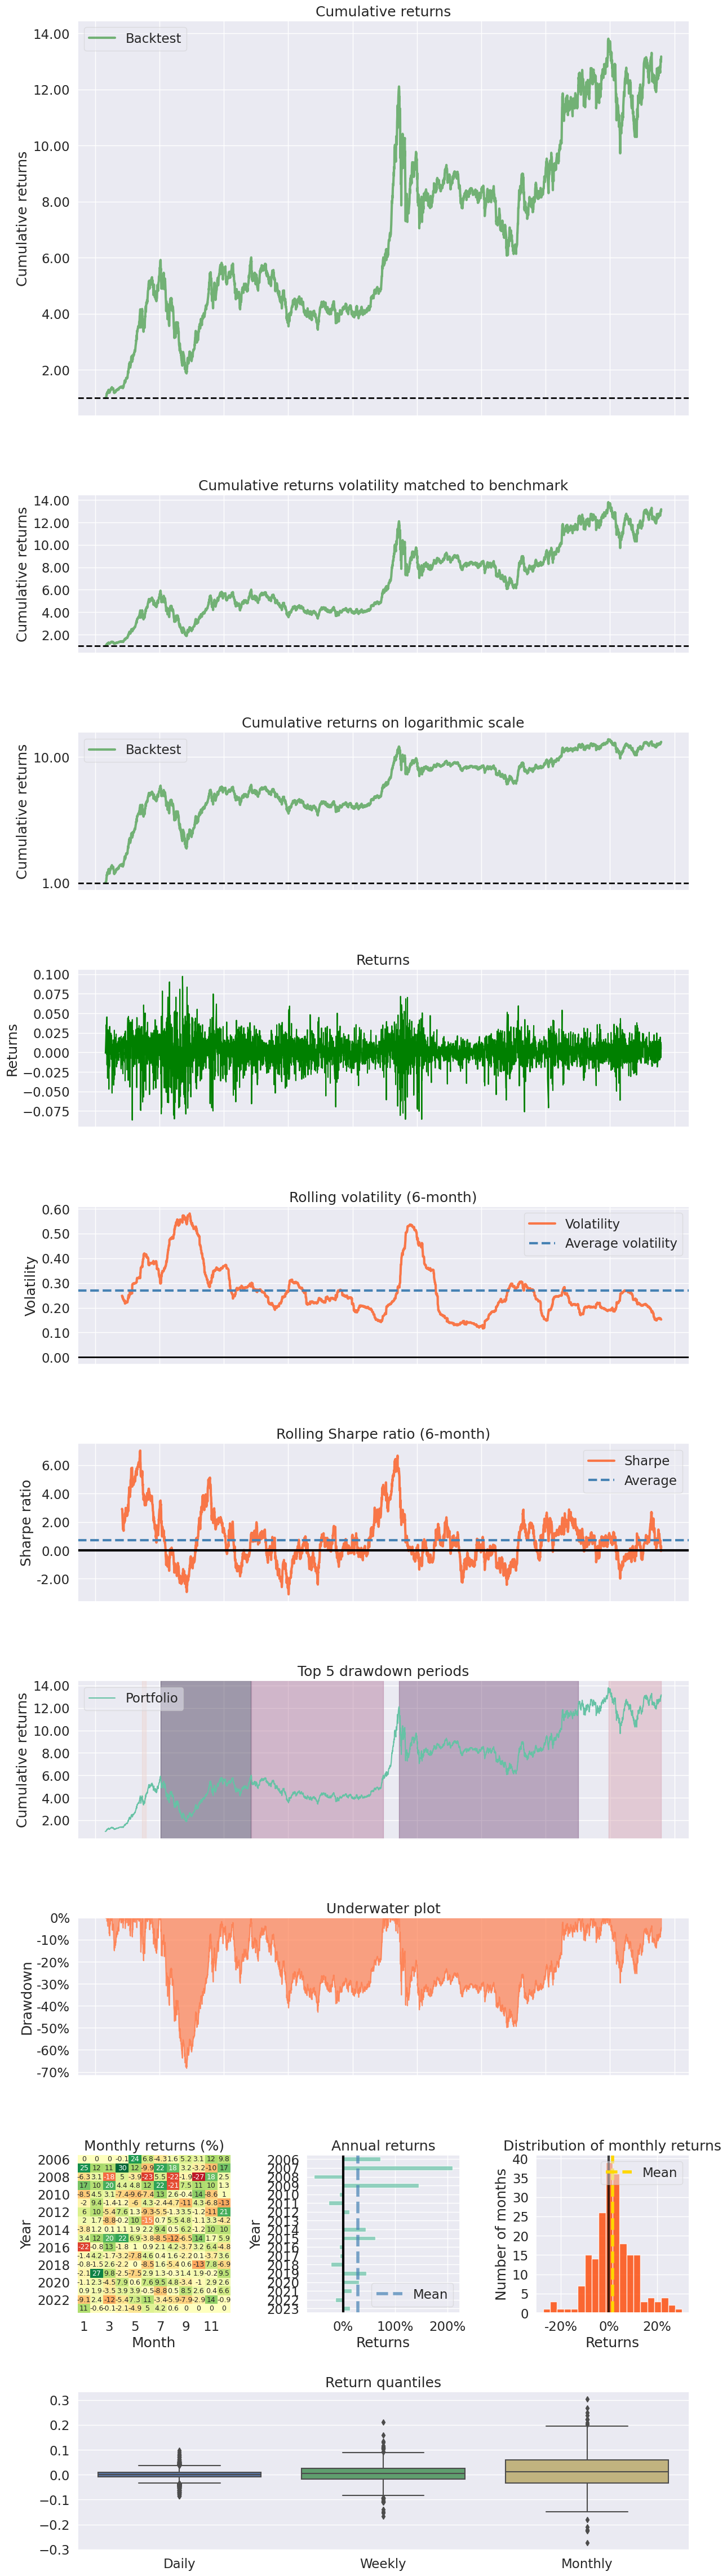

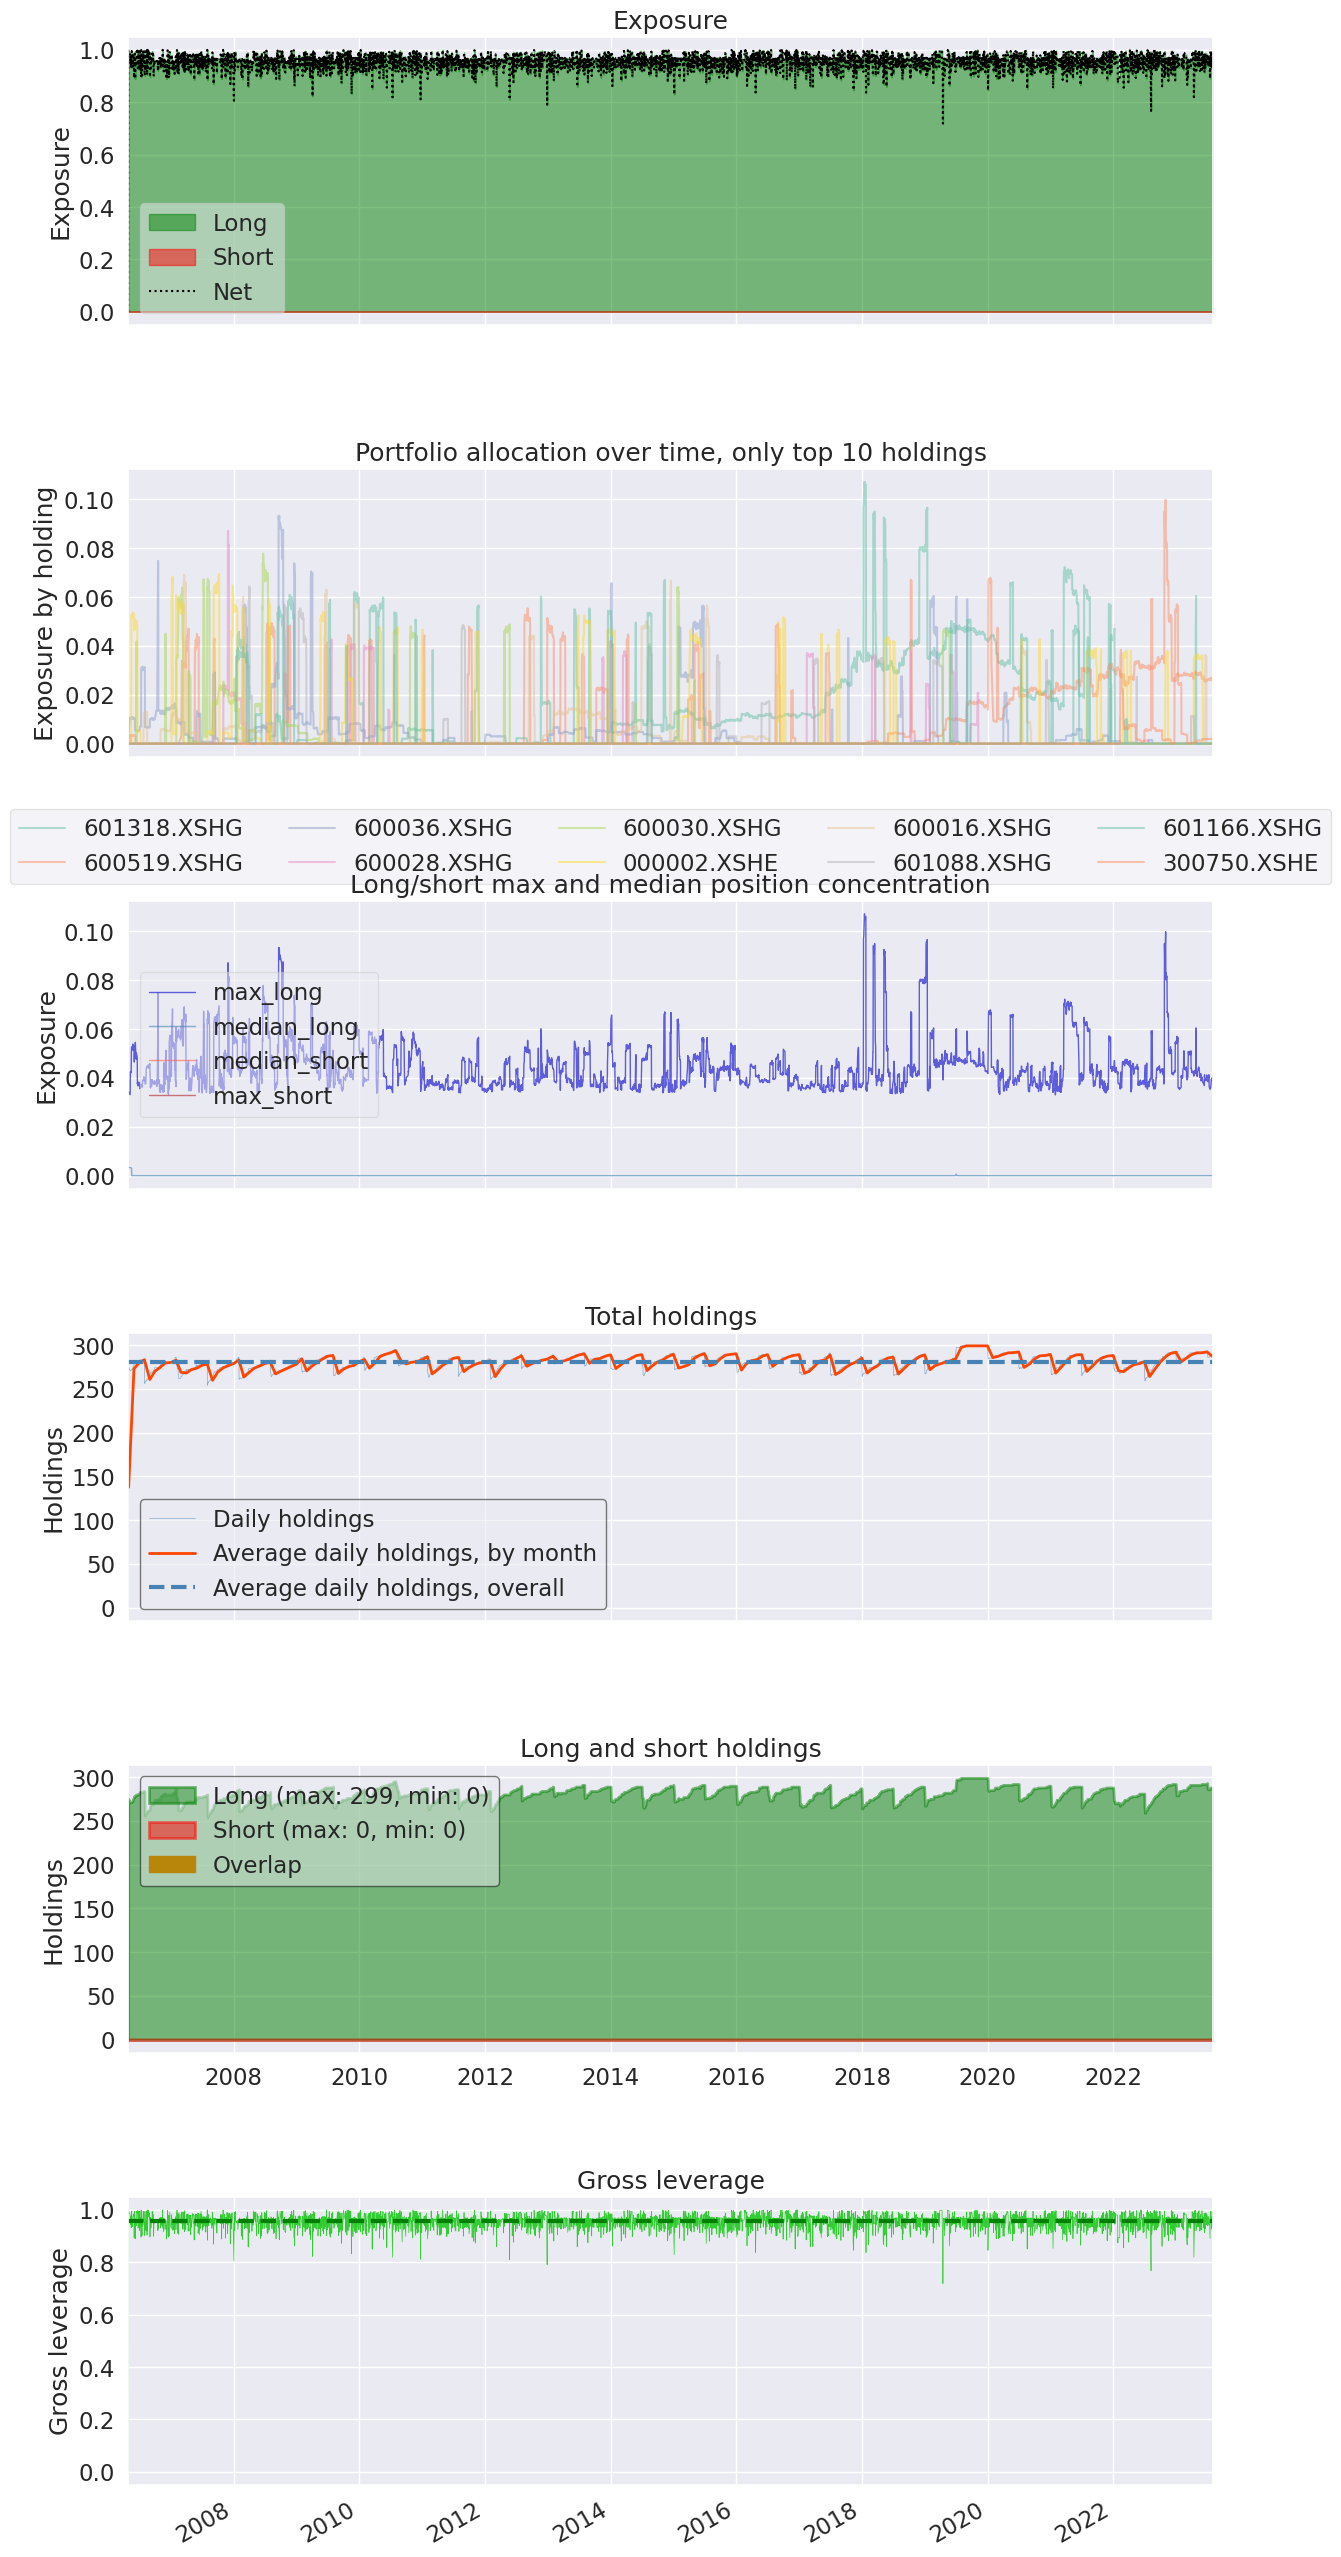

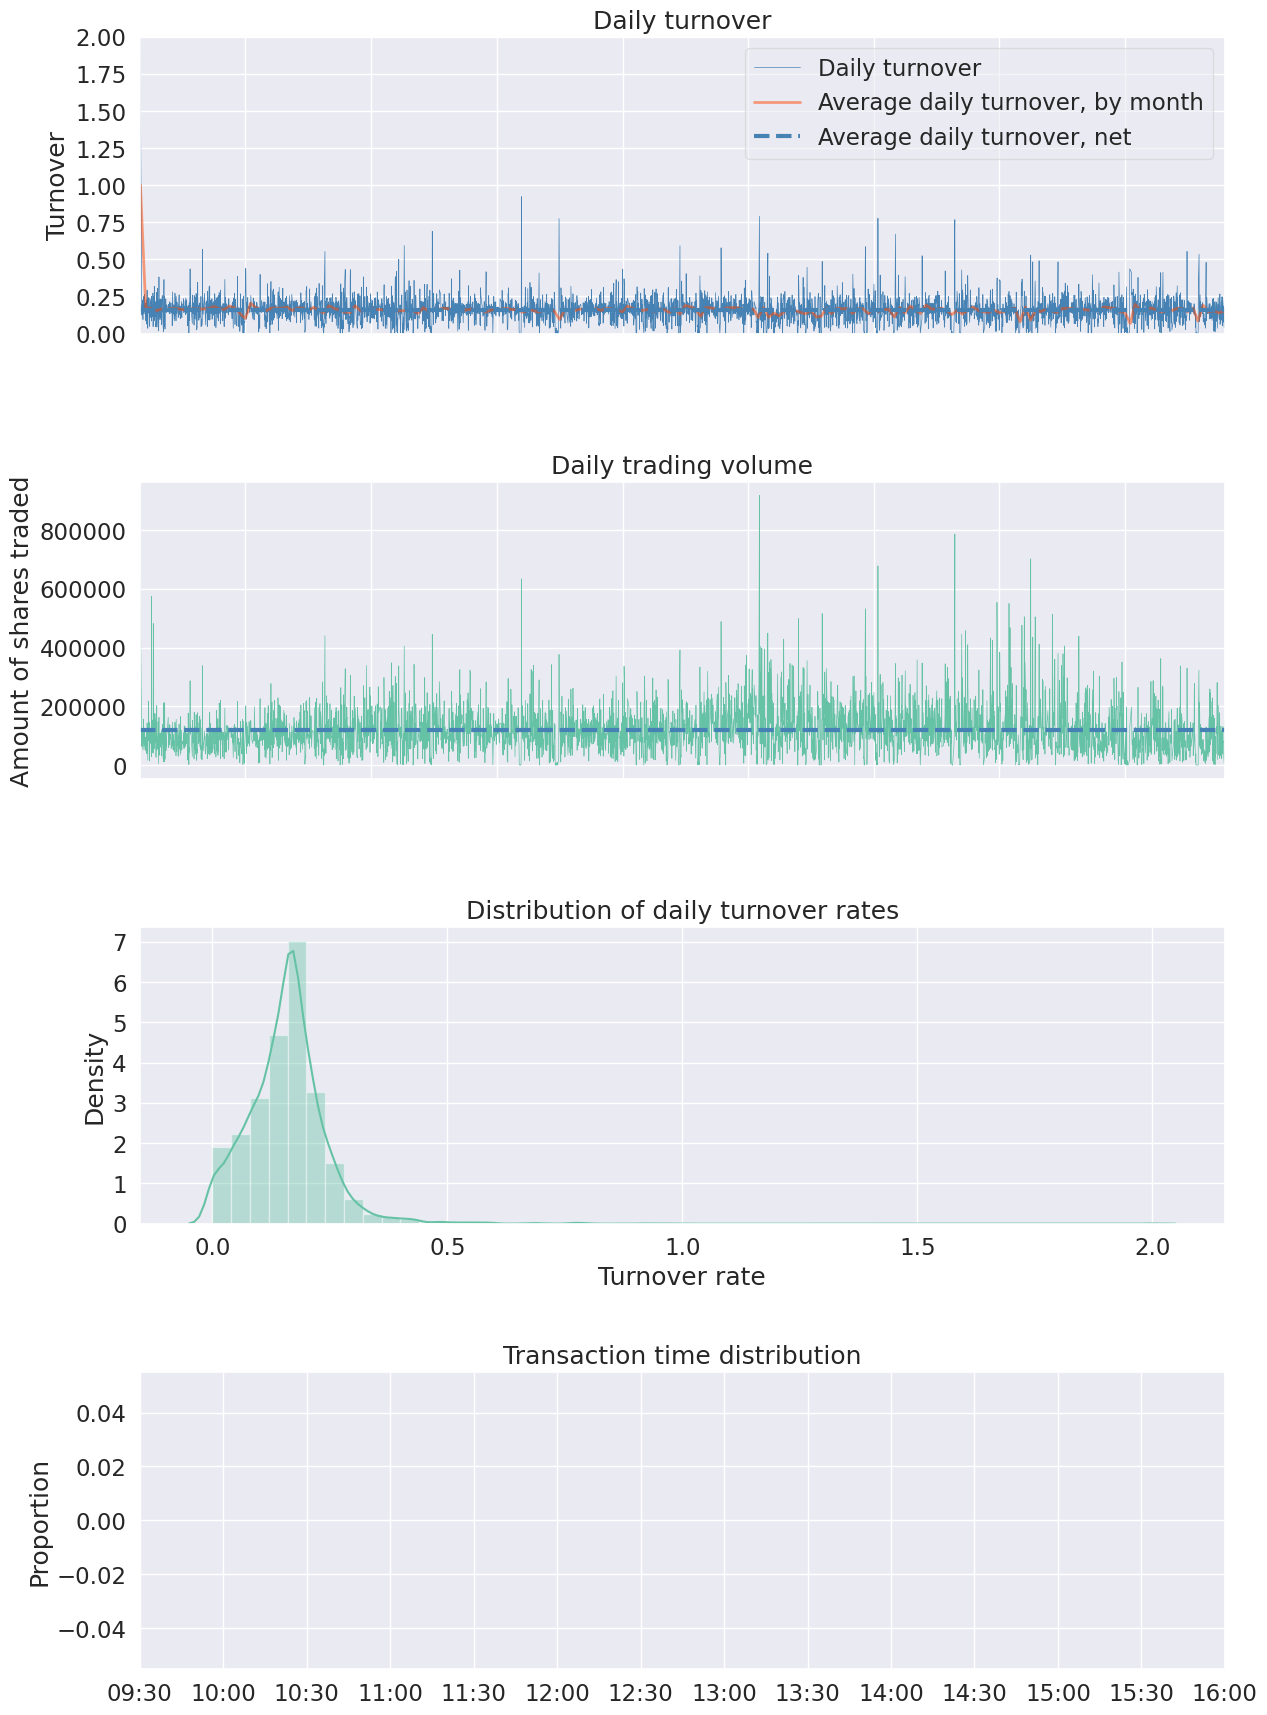

In [23]:
import pyfolio as pf
pf.create_full_tear_sheet(returns, positions=ps_df, transactions=transactions)

In [6]:
# backtest strategy
import bt
strategy = bt.Strategy('opt', [bt.algos.SelectAll(), 
                              bt.algos.WeighTarget(weights_df.shift(1)), 
                              bt.algos.Rebalance()])
backtest= bt.Backtest(strategy, 
                      close_df.loc[weights_df.index], 
                      initial_capital=100000, 
                      integer_positions=False,
                      commissions=lambda q, p: abs(q * p) * 0.001)

equal_strategy = bt.Strategy('equal', [bt.algos.SelectAll(),
                                       bt.algos.WeighTarget(equal_weight_df),
                                       bt.algos.Rebalance()])
backtest_equal = bt.Backtest(equal_strategy,
                             close_df.loc[weights_df.index],
                             integer_positions=False,
                             commissions=lambda q, p: abs(q * p) * 0.001)

buy_and_hold_strategy = bt.Strategy('buy_and_hold', [bt.algos.SelectAll(),
                                                     bt.algos.WeighEqually(),
                                                     bt.algos.Rebalance()])
# res = bt.run(backtest)
backtest_bah = bt.Backtest(buy_and_hold_strategy,
                       index_history.loc[weights_df.index, ['close']],
                       )




<Axes: title={'center': 'Equity Progression'}>

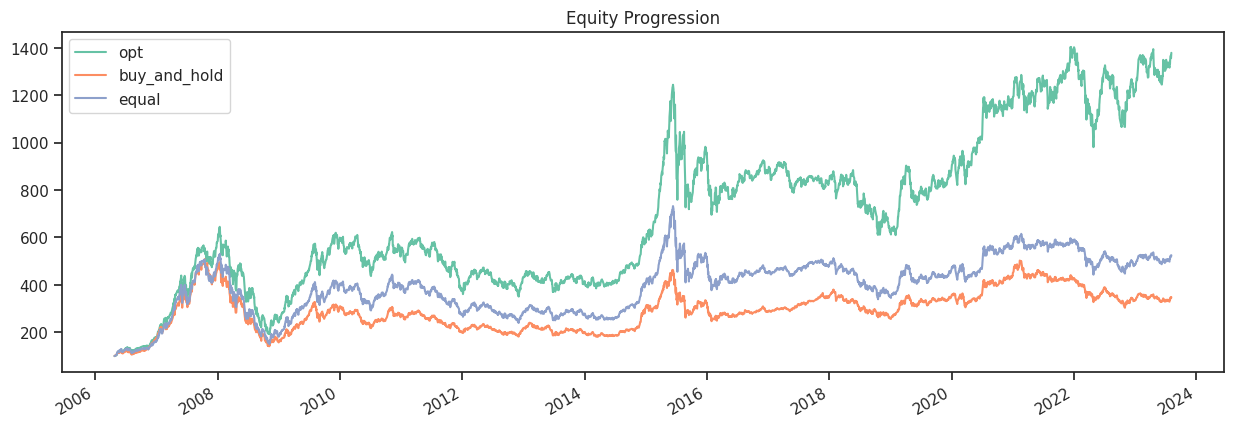

In [8]:
res = bt.run(backtest, backtest_bah, backtest_equal)
res.plot()

In [9]:
res.stats

,opt,buy_and_hold,equal
start,2006-04-26 00:00:00,2006-04-26 00:00:00,2006-04-26 00:00:00
end,2023-08-04 00:00:00,2023-08-04 00:00:00,2023-08-04 00:00:00
rf,0.0,0.0,0.0
total_return,12.783032,2.478493,4.247504
cagr,0.164021,0.074838,0.100729
max_drawdown,-0.701641,-0.72294,-0.715535
calmar,0.233767,0.103519,0.140775
mtd,0.00862,0.001482,0.003214
three_month,0.061253,-0.002399,0.017865
six_month,0.020032,-0.029222,0.004788


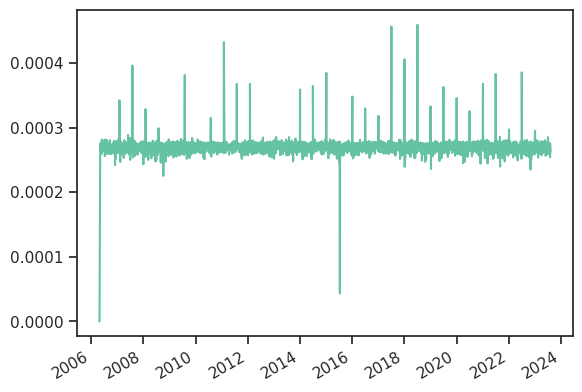

In [8]:
# just to check if it is same as target weight
(res.get_security_weights('opt') - weights_df.shift(1)).abs().sum(axis=1).plot()

In [9]:
strategy.positions

""


Start date,2006-04-26
End date,2023-08-04
Total months,200
,Backtest
Annual return,17.0%
Cumulative returns,1278.3%
Annual volatility,30.1%
Sharpe ratio,0.67
Calmar ratio,0.24
Stability,0.74
Max drawdown,-70.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,69.63,2008-01-14,2008-11-03,2015-02-13,1850
1,50.65,2015-06-12,2019-01-30,2021-01-08,1456
2,29.11,2021-12-13,2022-04-25,NaT,NaN
3,16.07,2007-05-29,2007-07-04,2007-07-30,45
4,14.84,2007-10-09,2007-11-27,2007-12-27,58


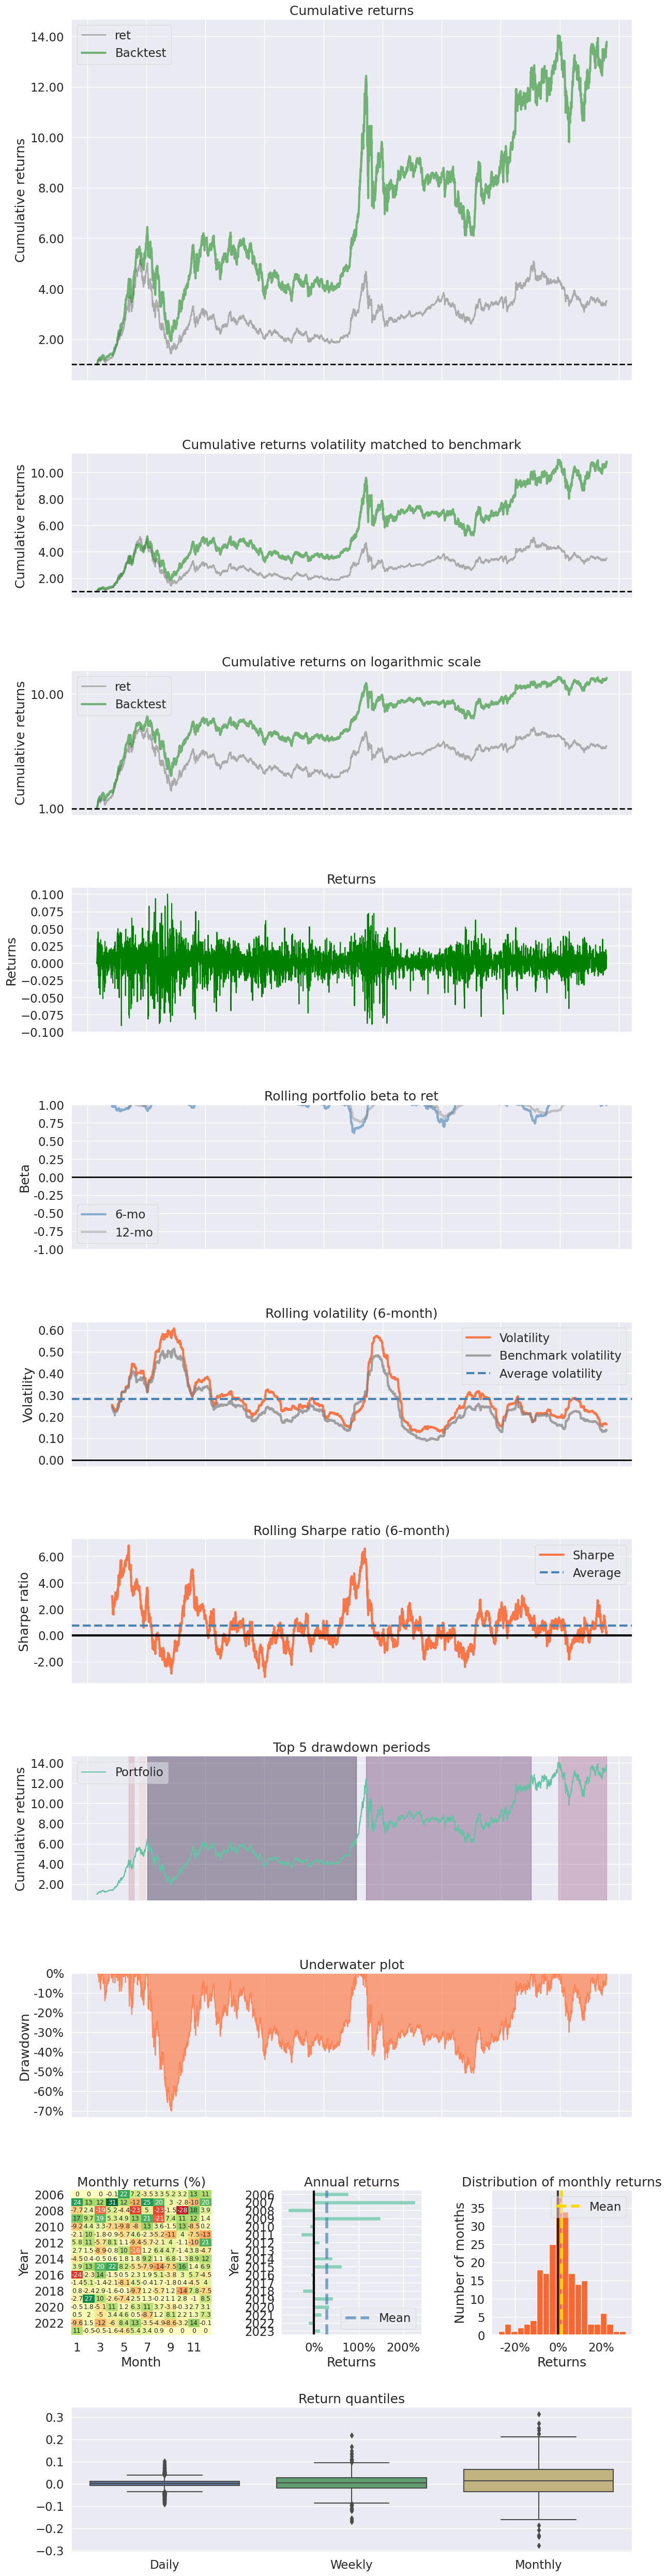

In [12]:
import pyfolio as pf


str_rets = backtest.strategy.prices.pct_change().fillna(0)
benchmark_rets = index_history['ret'].fillna(0).loc[str_rets.index]
pf.create_returns_tear_sheet(str_rets, benchmark_rets=benchmark_rets)

